# Census
Natalia Vélez, December 2019

In [1]:
%matplotlib inline

import os, re, glob
import numpy as np
import pandas as pd
from os.path import join as opj
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
from calmap import calendarplot, yearplot

Helper functions:

In [2]:
gsearch = lambda *args: glob.glob(opj(*args))
str_extract = lambda pattern, s: re.search(pattern, s).group(0)

## Load data

Find data files:

In [8]:
data_dir = '../data'
data_files = gsearch(data_dir, 'publicLifeLogData', 'lifeLog*', '*y.txt')
print(*data_files[:10], sep='\n')

../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_01January_17_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_31_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2018_08August_04_Saturday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2018_09September_18_Tuesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_12December_25_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_03March_18_Monday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2018_04April_05_Thursday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2018_05May_20_Sunday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2018_05May_09_Wednesday.txt
../data/publicLifeLogData/lifeLog_server14.onehouronelife.com/2019_08August_29_Thursday.txt


Load each file, tabulate # of births and deaths:

In [10]:
data_list = []

for f in tqdm_notebook(data_files):
    
    server = str_extract('(?<=lifeLog_)[A-Za-z0-9]+', f)

    year = str_extract('[0-9]{4}', f)
    month = str_extract('(?<=[0-9]{4}_)[0-9]{2}', f)
    day = str_extract('[0-9]{2}(?=_[A-Za-z]+.txt)', f)
    date = '%s-%s-%s' % (year, month, day)

    # Read data
    try:
        tmp_d = pd.read_csv(f, sep=' ', header=None,
                            encoding = 'ISO-8859-1', engine='python', error_bad_lines=False)
        tmp_d.head()

        # Tally events
        n_deaths = np.sum(tmp_d.iloc[:,0] == 'D')
        n_births = np.sum(tmp_d.iloc[:,0] == 'B')
    except pd.errors.EmptyDataError:
        
        n_deaths = 0
        n_births = 0

    data_list.append([server, year, month, day, date, n_deaths, n_births])

Skipping line 7341: Expected 9 fields in line 7341, saw 12
Skipping line 7610: Expected 9 fields in line 7610, saw 12
Skipping line 7803: Expected 9 fields in line 7803, saw 13
Skipping line 7998: Expected 9 fields in line 7998, saw 15
Skipping line 8113: Expected 9 fields in line 8113, saw 16
Skipping line 8191: Expected 9 fields in line 8191, saw 10
Skipping line 8229: Expected 9 fields in line 8229, saw 12
Skipping line 8268: Expected 9 fields in line 8268, saw 11
Skipping line 8305: Expected 9 fields in line 8305, saw 15
Skipping line 8343: Expected 9 fields in line 8343, saw 16
Skipping line 8380: Expected 9 fields in line 8380, saw 17
Skipping line 8420: Expected 9 fields in line 8420, saw 17
Skipping line 8459: Expected 9 fields in line 8459, saw 14
Skipping line 6848: Expected 9 fields in line 6848, saw 15
Skipping line 5364: Expected 9 fields in line 5364, saw 12
Skipping line 5407: Expected 9 fields in line 5407, saw 11
Skipping line 9224: Expected 9 fields in line 9224, saw 

Clean up data frame:

In [11]:
data = pd.DataFrame(data_list, 
                    columns=['server', 'year', 'month', 'day', 'date',
                             'n_deaths', 'n_births'])

# Change dates to correct datatype
date_cols = ['year', 'month', 'day']
data[date_cols] = data[date_cols].apply(pd.to_numeric, errors='coerce')
data['date'] = pd.to_datetime(data['date'])

# Sort
data.sort_values(by=['date', 'server'], inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,server,year,month,day,date,n_deaths,n_births
0,server10,2018,3,6,2018-03-06,3,4
1,server2,2018,3,6,2018-03-06,7245,7245
2,server3,2018,3,6,2018-03-06,5195,5192
3,server4,2018,3,6,2018-03-06,2310,2316
4,server5,2018,3,6,2018-03-06,1629,1624


## Overall activity in each server

Total events:

In [12]:
total_deaths = np.sum(data['n_deaths'])
total_births = np.sum(data['n_births'])

print('Deaths: %i' % total_deaths)
print('Births: %i' % total_births)

Deaths: 7188299
Births: 7200060


Aggregate birth/deaths by server, collapsing across all dates:

In [13]:
# Aggregate & reshape
server_summ = data.groupby(['server'])['n_deaths', 'n_births'].agg('sum').reset_index()
server_summ = server_summ.melt(id_vars=['server'],
                               value_vars=['n_deaths', 'n_births'],
                               var_name='event', value_name='n')

# Clean up dataframe
server_summ['event'] = server_summ['event'].apply(lambda s: s.replace('n_', ''))
server_summ.sort_values(by=['server', 'event'], inplace=True)

server_summ.head()

,server,event,n
17,bigserver1,births,48932
0,bigserver1,deaths,48743
18,bigserver2,births,2431873
1,bigserver2,deaths,2427713
19,server1,births,1949889


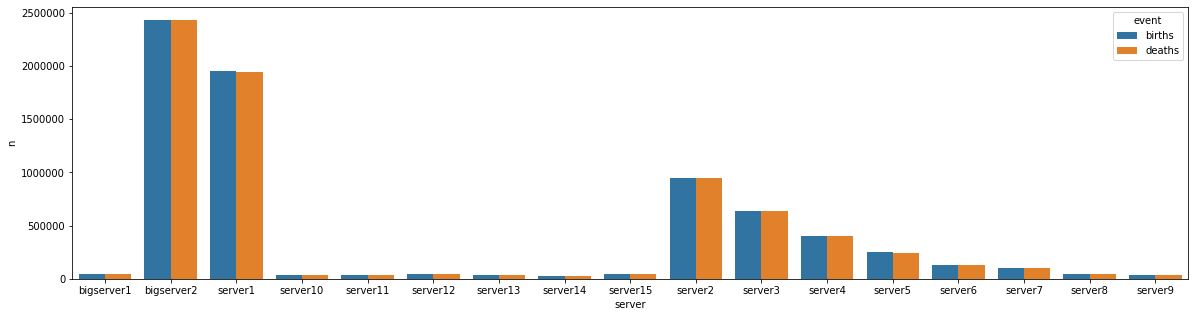

In [14]:
plt.figure(figsize=(20,5))
g = sns.barplot(data=server_summ, x='server', y='n', hue='event')

Log scale:

[None, (1, 2500000.0)]

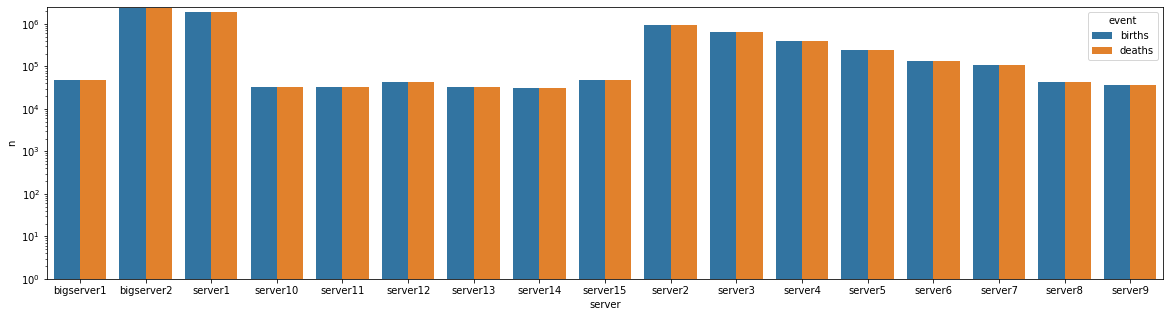

In [15]:
plt.figure(figsize=(20,5))
g = sns.barplot(data=server_summ, x='server', y='n', hue='event')

# Set scale
max_scale = np.amax(server_summ['n'])
ymin = 1
ymax = np.ceil(max_scale/500000)*500000
g.set(yscale='log', ylim=[ymin, ymax])

## Activity by date

### Overall

Aggregate activity by date, collapsing across servers:

In [16]:
data_across_servers = data.groupby(['year', 'month','day',  'date'])['n_deaths', 'n_births']
date_summ = data_across_servers.agg('sum').reset_index()

date_summ.head()

,year,month,day,date,n_deaths,n_births
0,2018,3,6,2018-03-06,16521,16535
1,2018,3,7,2018-03-07,20738,20792
2,2018,3,8,2018-03-08,30645,30680
3,2018,3,9,2018-03-09,63397,63469
4,2018,3,10,2018-03-10,72191,72268


Calendar plot:

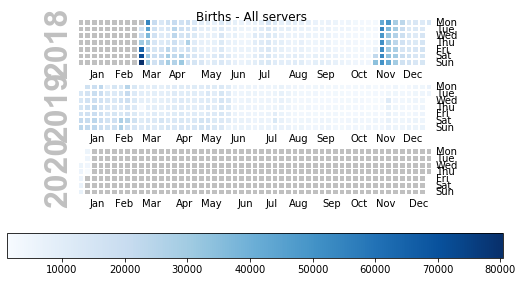

In [17]:
birth_events = pd.Series(date_summ['n_births'].values, index=date_summ['date'])

fig,ax = calendarplot(birth_events, cmap='Blues', fillcolor='silver',
                      fig_kws={'figsize':(8,4)})
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation = 'horizontal')
fig.suptitle('Births - All servers')
fig.savefig('plots/census_births_all.png')

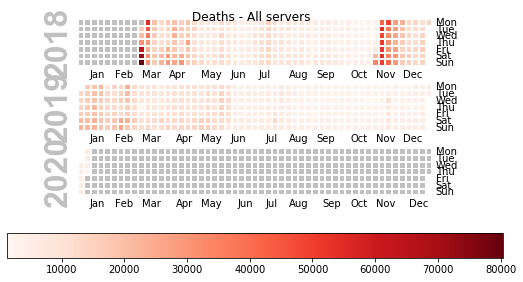

In [18]:
death_events = pd.Series(date_summ['n_deaths'].values, index=date_summ['date'])

fig,ax = calendarplot(death_events, cmap='Reds', fillcolor='silver',
                      fig_kws={'figsize':(8,4)})
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation = 'horizontal')
fig.suptitle('Deaths - All servers')
fig.savefig('plots/census_deaths_all.png')

### By server

In [19]:
servers = data['server'].unique()
servers.sort()
print(servers)
print('Plotting activity for %i servers' % len(servers))

['bigserver1' 'bigserver2' 'server1' 'server10' 'server11' 'server12'
 'server13' 'server14' 'server15' 'server2' 'server3' 'server4' 'server5'
 'server6' 'server7' 'server8' 'server9']
Plotting activity for 17 servers


Helper function: Generate calendar plot of births for each server

In [20]:
def server_calendar(s):
    s_data = data[data['server'] == s]

    # Plot births
    s_births = pd.Series(s_data['n_births'].values, index=s_data['date'])

    fig,ax = calendarplot(s_births, cmap='Blues', fillcolor='silver',
                          fig_kws={'figsize':(8,4)})
    fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation = 'horizontal')
    fig.suptitle('Births - %s' % s)
    fig.savefig('plots/census_births_%s.png' % s)

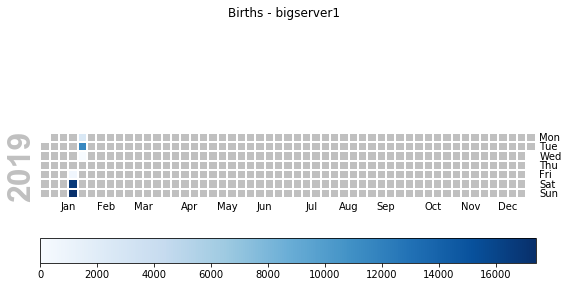

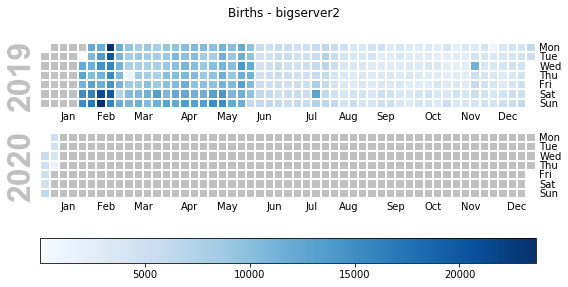

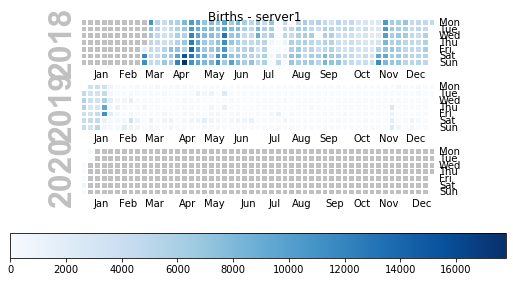

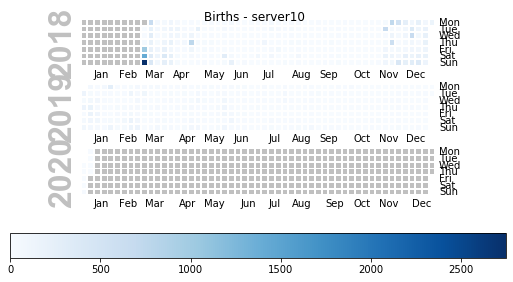

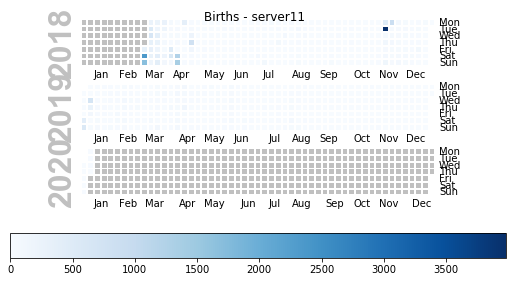

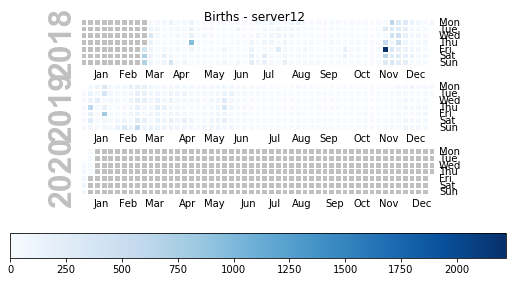

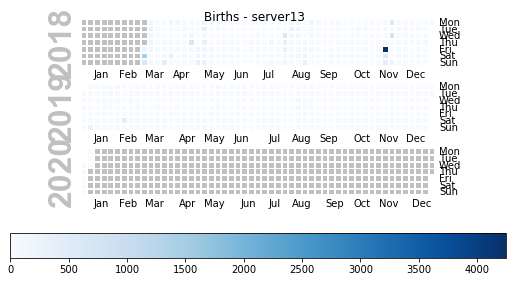

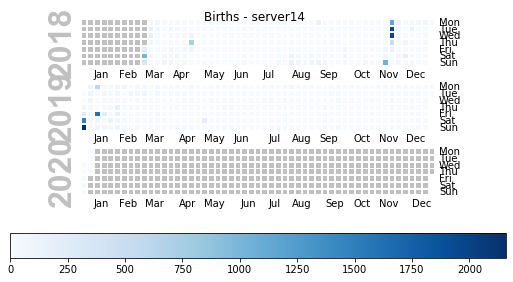

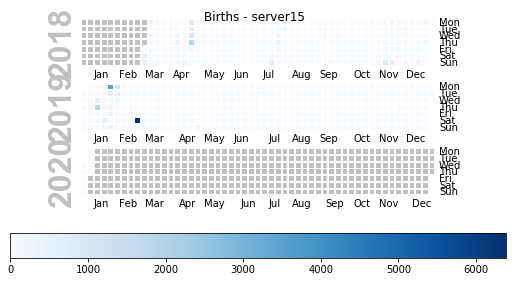

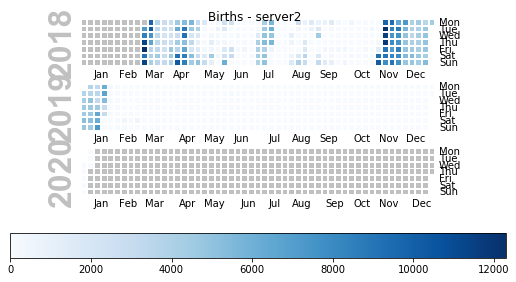

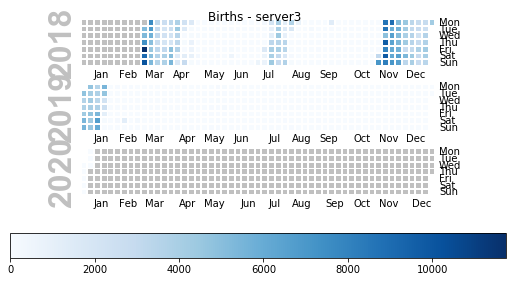

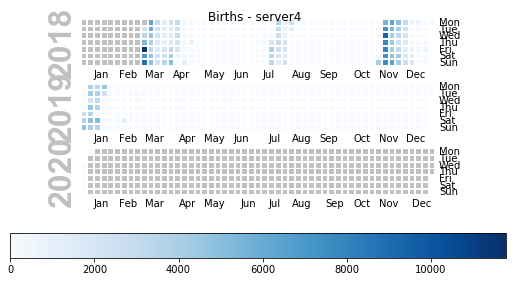

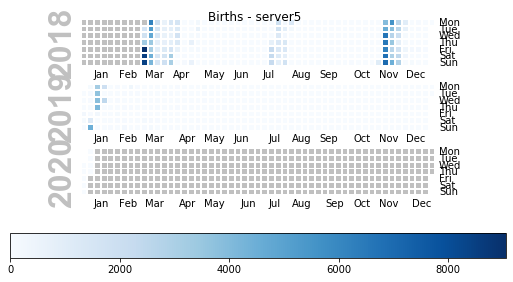

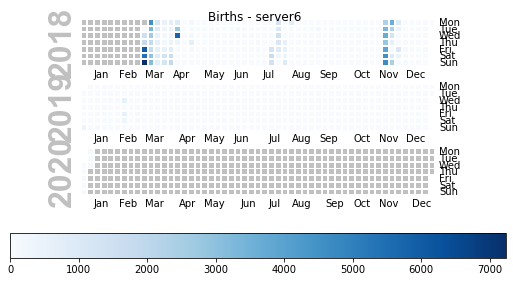

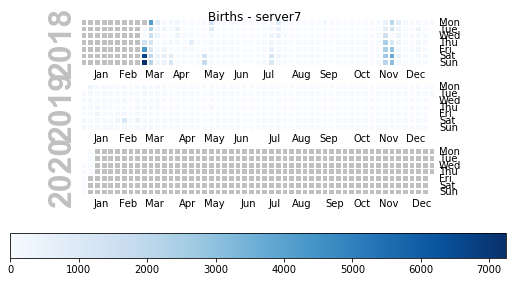

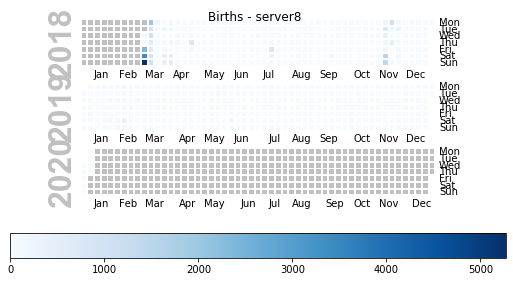

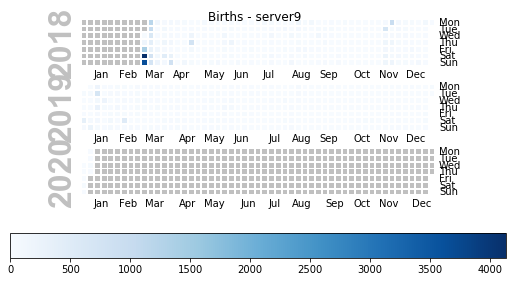

In [21]:
for s in servers:
    server_calendar(s)

In [22]:
data.head()

,server,year,month,day,date,n_deaths,n_births
0,server10,2018,3,6,2018-03-06,3,4
1,server2,2018,3,6,2018-03-06,7245,7245
2,server3,2018,3,6,2018-03-06,5195,5192
3,server4,2018,3,6,2018-03-06,2310,2316
4,server5,2018,3,6,2018-03-06,1629,1624
